# 2.2: Assessing results #

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S2.2 - Resolution and uncertainty-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this practical, we will look again at the X-Ray tomography example, and investigate some factors that may affect the quality of results.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/msambridge/InversionPracticals
# %cd InversionPracticals/Solutions

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../software")
import xrayTomography as xrt

In the last practical, our dataset for XRT was evenly-sampled, with a good path coverage across the entire dataset. What happens when this is not the case? The file `xrt_dataset_uneven.dat` contains a different set of experimental data, where the path coverage is extremely variable. The format is identical to that described in the last practical.

**Task 1:** Load the dataset and prepare it for inversion.

In [3]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 
dataset = np.loadtxt('../datasets/xrt_dataset_uneven.dat')
dataset[0,:]
d = np.zeros([np.shape(dataset)[0],2])
d = -np.log(dataset[:,5]) + np.log(dataset[:,2])
paths = np.zeros([np.shape(dataset)[0],4])
paths[:,0] = dataset[:,0]
paths[:,1] = dataset[:,1]
paths[:,2] = dataset[:,3]
paths[:,3] = dataset[:,4]
#np.shape(dataset)


How can we visualise the path coverage in this example? Remember, each row of our matrix '$\mathbf{A}$' tells us about the amount of time one path spends in each cell. So, if we compute `A.mean(0)`, we can obtain the average time spent per cell across *all* paths in the dataset.

** Task 2:** Make a plot showing the ray coverage for this example. How do you think this is going to affect results? Where do you expect your recovered model to perform well? What do you think will happen in areas of low coverage?

Evaluating paths: 100%|██████████████████████████████████████████████████████████████████████| 5561/5561 [00:00<00:00, 14021.01it/s]


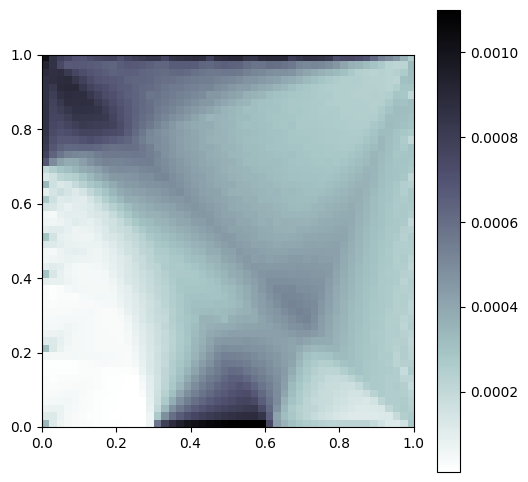

In [4]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

model = np.ones([50,50])
attns, A = xrt.tracer(model,paths)
#xrt.displayModel(model,paths=paths)
P = A.mean(0).reshape(np.shape(model))
xrt.displayModel(P)

**Task 3:** Perform the inversion and plot your results. How do they compare with what you anticipated? How well does the model perform in terms of generating predictions that match the 'real' data?

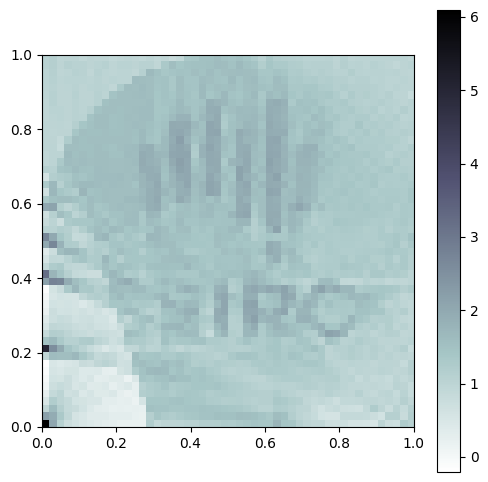

In [5]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 
def solveInverseProblem(A,d,epsSquared):
    np.shape(A)[1]
    m = np.linalg.inv((A.T).dot(A) + epsSquared*np.eye(np.shape(A)[1])).dot(A.T).dot(d)
    return m
m = solveInverseProblem(A,d,0.001)
xrt.displayModel(m.reshape(np.shape(model)))

As we have discussed, a Bayesian approach to least squares indicates that if our prior knowledge is given by

$$\mathsf{m}\sim \mathcal{N}\left(\mathbf{m_p},\mathbf{C_m}\right)$$ 

then our posterior knowledge, after observing a dataset $\mathbf{d_0}$, is given by


$$
\mathsf{m}\,|\,\mathbf{d_0} \sim\mathcal{N}\left(\mathbf{m_p} + \left(\mathbf{A^TC_d^{-1}A + C_m^{-1}}\right)^\mathbf{-1}\mathbf{A^TC_d^{-1}\left(d-Am_p\right)},\left(\mathbf{A^TC_d^{-1}A + C_m^{-1}}\right)^\mathbf{-1} \right)\,. 
$$

Here, $\mathbf{C_d}$ is the prior data covariance matrix - that is, we are assuming that $\mathbf{d_0}$ contains zero-mean normally distributed noise, so that $\mathbf{d_0}\sim\mathcal{N}\left(\mathbf{d_{true}},\mathbf{C_d}\right)$.

**Task 4:** What prior information are you currently assuming in your inversion? Is this a reasonable choice? What happens if you use different priors? Why?

*Hint:* You should change not only $\mathbf{C_m}$, but also $\mathbf{m_p}$ and $\mathbf{C_d}$! Note that $\mathbf{C_d}$ is a large matrix, and explicitly inverting it may be computationally expensive. However, if we simply have a standard deviation on each data point (let's suppose they are in an array called `sigma`) then we can do the following:
```python
Cd = np.diag(sigma**2)       # C_d
invCd = np.diag(1./sigma**2) # C_d^{-1}
```
Note that the diagonal entries of the covariance matrix should be the *variances* on each data point, i.e. the square of the standard deviation!

In [6]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

def solveInverseProblem2(A,d,sigma,mp,invCm):
    np.shape(A)[1]
    Cd = np.diag(sigma**2)       # C_d
    invCd = np.diag(1./sigma**2) # C_d^{-1}
    m = mp + np.linalg.inv((A.T).dot(invCd).dot(A) + invCm).dot(A.T).dot(invCd).dot(d-A.dot(mp))
    return m

The posterior covariance matrix gives information about the uncertainties associated with the recovered model. In particular, the diagonal elements of the posterior covariance matrix can be interpreted as the variance on the value in each grid cell.

**Task 5:** Plot the posterior covariance matrix, and the uncertainties in individual parameters. How do these relate to the ray coverage?

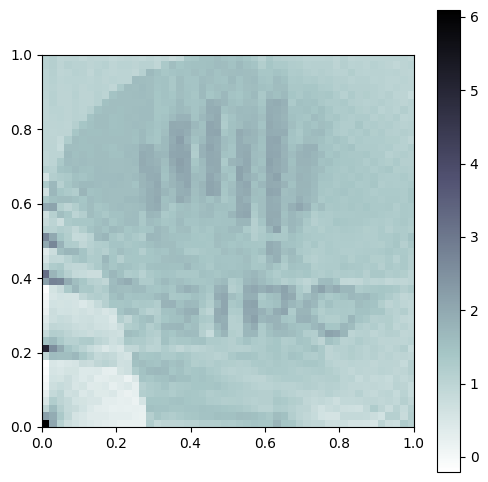

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 
sigmad = 1.0
#dnoise = np.random.normal(0, sigmad, len(d))
dnoise = 0.0
#print(np.var(d))
sigmam = np.sqrt(1000)
sigmam = sigmam*np.ones(len(m))
invCm = np.diag(1./sigmam**2) # C_m^{-1}
#print(invCm)
mp = np.zeros(len(m))
d = d + dnoise                         
m = solveInverseProblem2(A,d,sigmad*np.ones(len(d)),mp,invCm)
xrt.displayModel(m.reshape(np.shape(model)))

We have also discussed the concept of the 'resolution operator', which takes the form $$\mathbf{R} = \left(\mathbf{A^TA}+\epsilon^2\mathbf{I}\right)^\mathbf{-1}\mathbf{A^TA}$$ and which can be interpreted as the 'imaging filter', in the sense that $$\mathbf{m_{rec}} = \mathbf{Rm_{true}}\,.$$

**Task 6:** Compute and plot the resolution operator for this inverse problem. Then, using `xrt.pngToModel` to load a version of $\mathbf{m_{true}}$ discretized in the same way as your inversion, based on `true_model.png`. How does this look when viewed through the 'imaging filter'?

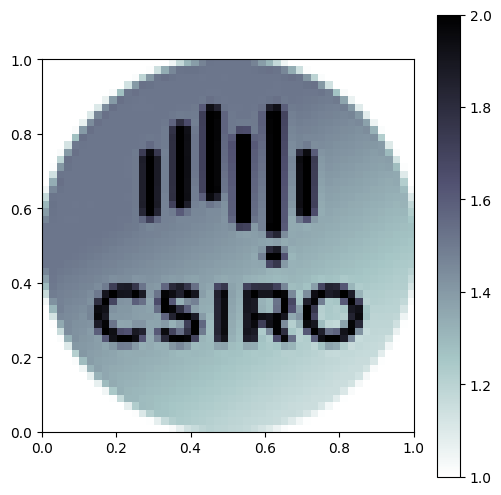

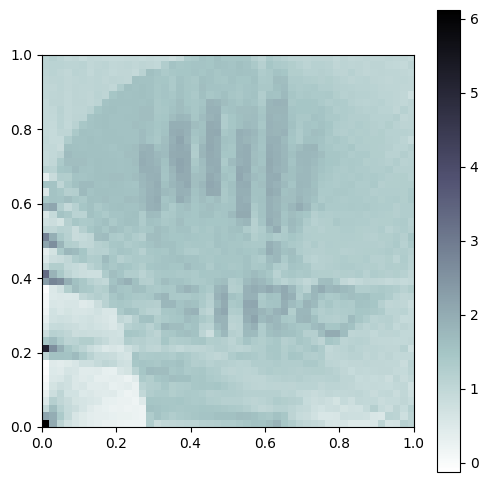

In [8]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 
c = xrt.pngToModel('../datasets/csiro_logo.png',50,50)
xrt.displayModel(c)
def ResOperator(A,sigma,mp,invCm):
    np.shape(A)[1]
    Cd = np.diag(sigma**2)       # C_d
    invCd = np.diag(1./sigma**2) # C_d^{-1}
    R =np.linalg.inv((A.T).dot(invCd).dot(A) + invCm).dot(A.T).dot(invCd).dot(A)
    return R
R = ResOperator(A,sigmad*np.ones(len(d)),mp,invCm)
Rm = R.dot(m)
xrt.displayModel(Rm.reshape(np.shape(model)))
#xrt.displayModel((Rm-m).reshape(np.shape(model)))

**Task 7:** The data you loaded from `xrt_dataset_uneven.dat` is noise-free. What happens if you add Gaussian random noise to $I_{rec}$ and repeat the above experiments? What if the noise levels are different on different samples?

In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 8:** Experiment with your own models and source/receiver configurations.

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



----